<a href="https://colab.research.google.com/github/Jeansds/Curso_Udemy---Deep-Learning-com-Python-de-A-a-Z/blob/master/Projeto_Petrobras_Multiplos_Previsores_Serie_Temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [0]:
base = pd.read_csv('/content/sample_data/petr4_treinamento.csv')
base = base.dropna()
base_treinamento = base.iloc[:, 1:7].values
normalizador = MinMaxScaler(feature_range = (0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [0]:

previsores = []
preco_real = []
for i in range(90, len(base_treinamento_normalizada)):
  previsores.append(base_treinamento_normalizada[i - 90: i, 0: 6])
  preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco = np.array(previsores), np.array(preco_real)

In [5]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], previsores.shape[2])))#return_sequences passa a informacao para as proxima camada LSTM
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])#testando com adam porem é possivel usar o rmsprop





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, 
                   patience = 10, verbose = 1) #ele percebe quando o resultado para de melhorar e para o treinamento 10/10 Função
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2,
                        patience = 5, verbose = 1)#reduz a taxa de aprendizagem para melhorar o valor da metrica se não perceber melhora
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss',
                      save_best_only = True, verbose = 1)#salva os pesos do modelo a cada epoch assim voce pode pegar o melhor modelo

In [7]:
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32,
              callbacks = [es, rlr, mcp])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





1152/1152 [==============================] - 14s 12ms/step - loss: 0.0215 - mean_absolute_error: 0.1115

Epoch 00001: loss improved from inf to 0.02155, saving model to pesos.h5
Epoch 2/100
1152/1152 [==============================] - 11s 10ms/step - loss: 0.0053 - mean_absolute_error: 0.0566

Epoch 00002: loss improved from 0.02155 to 0.00531, saving model to pesos.h5
Epoch 3/100
1152/1152 [==============================] - 11s 10ms/step - loss: 0.0042 - mean_absolute_error: 0.0504

Epoch 00003: loss improved from 0.00531 to 0.00417, saving model to pesos.h5
Epoch 4/100
1152/1152 [==============================] - 11s 10ms/step - loss: 0.0039 - mean_absolute_error: 0.0489

Epoch 00004: loss improved from 0.00417 to 0.00390, saving model to pesos.h5
Epoch 5/100
1152/1152 [==============================] - 11s 10ms/step - loss: 0.0032 - mean_absolute_error: 0.0438

Epoch 000

In [0]:
base_teste = pd.read_csv('/content/sample_data/petr4_teste.csv')
preco_real_teste = base_teste.iloc[:, 1:2].values

frames = [base, base_teste]
base_completa = pd.concat(frames)
base_completa = base_completa.drop('Date', axis = 1)
entradas = base_completa[len(base_completa) - len(base_teste)- 90:].values
entradas = normalizador.transform(entradas)# normalização das entradas valores entre 0 e 1

In [0]:
X_teste = []
for i in range(90, len(entradas)):
  X_teste.append(entradas[i-90: i, 0:6])
X_teste = np.array(X_teste)
previsores = regressor.predict(X_teste)
normalizador_previsor = MinMaxScaler(feature_range = (0, 1))
normalizador_previsor.fit_transform(base_treinamento[:,0: 1])
previsores = normalizador_previsor.inverse_transform(previsores)# desnormaliza os dados


In [16]:
for i in range(len(previsores)):
  print(previsores[i], preco_real_teste[i])
print("Diferença Media em centavos: " , ((previsores.mean() - preco_real_teste.mean())**2)**1/2)

[16.173498] [16.190001]
[16.251049] [16.49]
[16.378012] [16.780001]
[16.558084] [16.700001]
[16.743559] [16.74]
[16.90356] [17.030001]
[17.029766] [16.92]
[17.089094] [16.879999]
[17.116302] [17.040001]
[17.154934] [17.32]
[17.219614] [17.35]
[17.342539] [17.92]
[17.589972] [18.35]
[17.920555] [18.309999]
[18.2189] [18.26]
[18.41269] [18.4]
[18.467964] [18.42]
[18.558918] [19.34]
[18.735928] [19.620001]
[19.047068] [19.67]
[19.407402] [19.77]
[19.644646] [19.74]
Diferença Media em centavos:  0.02875591711888865


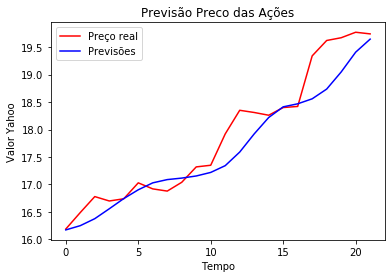

In [15]:

plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsores, color = 'blue', label = 'Previsões')
plt.title('Previsão Preco das Ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()